# Process Mining with sberpm

The __`sberpm`__ python library is designed to analyze business processes and solve related problems using machine learning and process mining techniques.

# DataHolder

The data of the business process should be an event log which stores the information about the sequence of activities in the process. Example of an event log: $W = \{(a, b, c, d), (a, c, b, d), (a, e, d) \}$, where the activities $ a $, $ b $, $ c $, $ d $ and $ e $ are sorted by their timestamps.

`DataHolder` is the data structure that contains the event log and its metainformation. It is used as an input argument by many PM algorithms.

In order to create a `DataHolder` object, it is possible either to specify a path to a log-file in the `DataHolder`'s constructor or provide the log in the form of a pandas DataFrame. It is also obligatory to set an __id_column__ and an __activity_column__. Moreover, for most Process Mining algorithms present in the library at least one of the timestamp columns (__start_timestamp_column__, __end_timestamp_column__) and a user column (__user_column__) are needed. 

### Parameters of DataHolder 

- **data (str or pd.DataFrame)** – path to a log-file (.csv, .xls(x), .txt) or pandas.DataFrame 
- **id_column (str)** – column that represents an ID of the event trace/case
- **activity_column (str)** – column that represents an activity
- __<font color='red'>*</font>start_timestamp_column (str)__ – timestamp that represents the beginning of activity execution
- __<font color='red'>*</font>end_timestamp_column (str)__ – timestamp that represents the end of activity execution
- __user_column (str)__ – column that represents the users who performed tasks in the process
- __text_column (str)__ – column with the textual data (e.g., comments)
- __duration_column (str)__ – column that contains the activity durations (If not given, it is calculated as *end_timestamp_column - start_timestamp_column*. If only one timestamp column is given, it is calculated as a difference between the timestamp of two consecutive activities, this leads to the duration of either the first or the last activity in the event trace to be NaN).
- __duration_unit (str)__ – unit of the values in a *duration_column* (needed only if the *duration_column* is given)

- __sep (str, default=',')__ – delimiter (used only if reading the log from file)
- __encoding (str)__ – encoding (used only if reading the log from file)
- __nrows (int)__ – number of rows to read from file (used only if reading the log from file)

- __preprocess (bool, default=True)__ – preprocessing of the data (sorting, removing/filling None-values, timestamp conversion), so that the library algorithms are able to work with the data
- __time_format (str)__ – format of the timestamp columns (strongly recommended to specify this parameter for correct time conversion). Time format syntax: https://docs.python.org/3/library/datetime.html#strftime-and-strptime-format-codes)
- __num_cpu (int, default=1)__ – maximum number of processors to use (for some operations that support multiprocessing)


__<font color='red'>*</font>__ For most algorithms it is needed to specify at least one of the timestamp columns. If it is unknown whether the timestamp column of the event log represents the start or end timestamp, it can be set as a __start_timestamp_column__. It is strongly recommended to specify __time_format__ parameter for correct time conversion.

### Creation of DataHolder Object

#### – using pandas DataFrame

In [1]:
from sberpm import DataHolder
import pandas as pd

df = pd.DataFrame({
    'id_column': [1, 1, 2, 2, 3, 3],
    'activity_column': ['st1', 'st2', 'st1', 'st3', 'st1','st2'],
    'start_timestamp_column': ['10.05.2020', '10.09.2020', '10.03.2020', '10.04.2020', '10.05.2020', '10.05.2020']
})

data_holder = DataHolder(data=df, 
                         id_column='id_column', 
                         activity_column='activity_column', 
                         start_timestamp_column='start_timestamp_column', 
                         time_format='%d.%m.%Y')

#### – using file path

In [2]:
path = 'example.csv'
data_holder = DataHolder(data=path, 
                         id_column='id', 
                         activity_column='stages', 
                         start_timestamp_column='dt', 
                         user_column='users', 
                         time_format='%Y-%m-%d')

When reading a log from a file, one can specify the parameters like __sep__, __encoding__, __nrows__ in the constructor of `DataHolder` if needed.

### Attributes of DataHolder
`DataHolder` stores the names of the key columns of the event log and gives an easy access to them:
- id_column
- activity_column
- start_timestamp_column
- end_timestamp_column
- user_column
- text_column
- duration_column

Moreover, `DataHolder` stores the original preprocessed log and its version grouped by *id_column* with some other columns aggregated to tuples (calculated in a lazy way when needed by some algorithms or if one calls a specific method) in the form of pandas DataFrames:
- data
- grouped_data

### Methods of DataHolder
- __check_or_calc_duration( )__ – calculate the execution time of each activity (in seconds) if not calculated before
- __get_grouped_data(...)__ – return the data (log) grouped by *id_column* with the given columns aggregated to tuples (e.g., activity_column or start_timestamp_column)
- __get_unique_activities( )__ – return the list of unique activities
- __get_columns( )__ – return the names of the columns in the event log
- __get_text( )__ – return the name of the column with the textual data if it was specified

In [3]:
data_holder.data.head(3)

,id,stages,dt,users
0,0.0,Stage_0,2019-12-01,Oliver
1,0.0,Stage_3,2019-12-02,Liam
2,0.0,Stage_5,2019-12-05,Emma


In [4]:
data_holder.check_or_calc_duration()

In [5]:
data_holder.data.head(3)

,id,stages,dt,users,duration
0,0.0,Stage_0,2019-12-01,Oliver,86400.0
1,0.0,Stage_3,2019-12-02,Liam,259200.0
2,0.0,Stage_5,2019-12-05,Emma,518400.0


In [6]:
data_holder.get_grouped_data(data_holder.activity_column, data_holder.start_timestamp_column).head()

,id,stages,dt
0,0.0,"(Stage_0, Stage_3, Stage_5, Stage_2, Stage_7)","(2019-12-01 00:00:00, 2019-12-02 00:00:00, 201..."
1,1.0,"(Stage_0, Stage_2, Stage_4, Stage_3, Stage_8)","(2019-12-01 00:00:00, 2019-12-06 00:00:00, 201..."
2,10.0,"(Stage_0, Stage_2, Stage_5, Stage_7)","(2019-12-01 00:00:00, 2019-12-06 00:00:00, 201..."
3,100.0,"(Stage_2, Stage_3, Stage_8)","(2019-12-01 00:00:00, 2019-12-09 00:00:00, 201..."
4,101.0,"(Stage_0, Stage_2, Stage_5, Stage_3, Stage_7, ...","(2019-12-01 00:00:00, 2019-12-10 00:00:00, 201..."


# Miners and visuzlization

In [7]:
import warnings
warnings.filterwarnings('ignore')

Having the event log of a business process, one can build the process model in the form of a graph by using the algorithms called *miners* and visualize it.

In order to do this, the library provides a number of algorithms that are stored in the module __`sberpm.miners`__ and they all have the only method:
- __apply( )__ – create a graph of the process that is stored in the *graph* attribute

## 1. SimpleMiner

`SimpleMiner` displays all edges found in the log (no filtering is applied).

Using the formal Process Mining language:
> The situation when activity $X$ is directly followed by $Y$ in at least one trace in the event log ($...XY...$) is called the _follows_ relation and denoted as $X>Y$ ($Y$ follows $X$).

SimpleMiner depicts the edges between the activities $X$ and $Y$, if $X>Y$.

In [8]:
from sberpm.miners import SimpleMiner

In [9]:
# Creation of the miner object. It takes DataHolder and the parameters of the algorithm
# (this miner does not have any additional parameters).
simple_miner = SimpleMiner(data_holder)

# Calculation.
simple_miner.apply()

# Getting the result
graph = simple_miner.graph

### Visualization of the Graph
For the purpose of visualization `GraphvizPainter` from the module __`sberpm.visual`__ should be used.

In [10]:
%matplotlib inline
from sberpm.visual import GraphvizPainter

Class `GraphvizPainter` has the following methods:
- __apply(...)__ – take a graph and prepare it for being visualized
- __write_graph(...)__ – save the graph in the given format (pdf, svg, gv, png)
- __show( )__ – show the graph in Jupyter Notebook

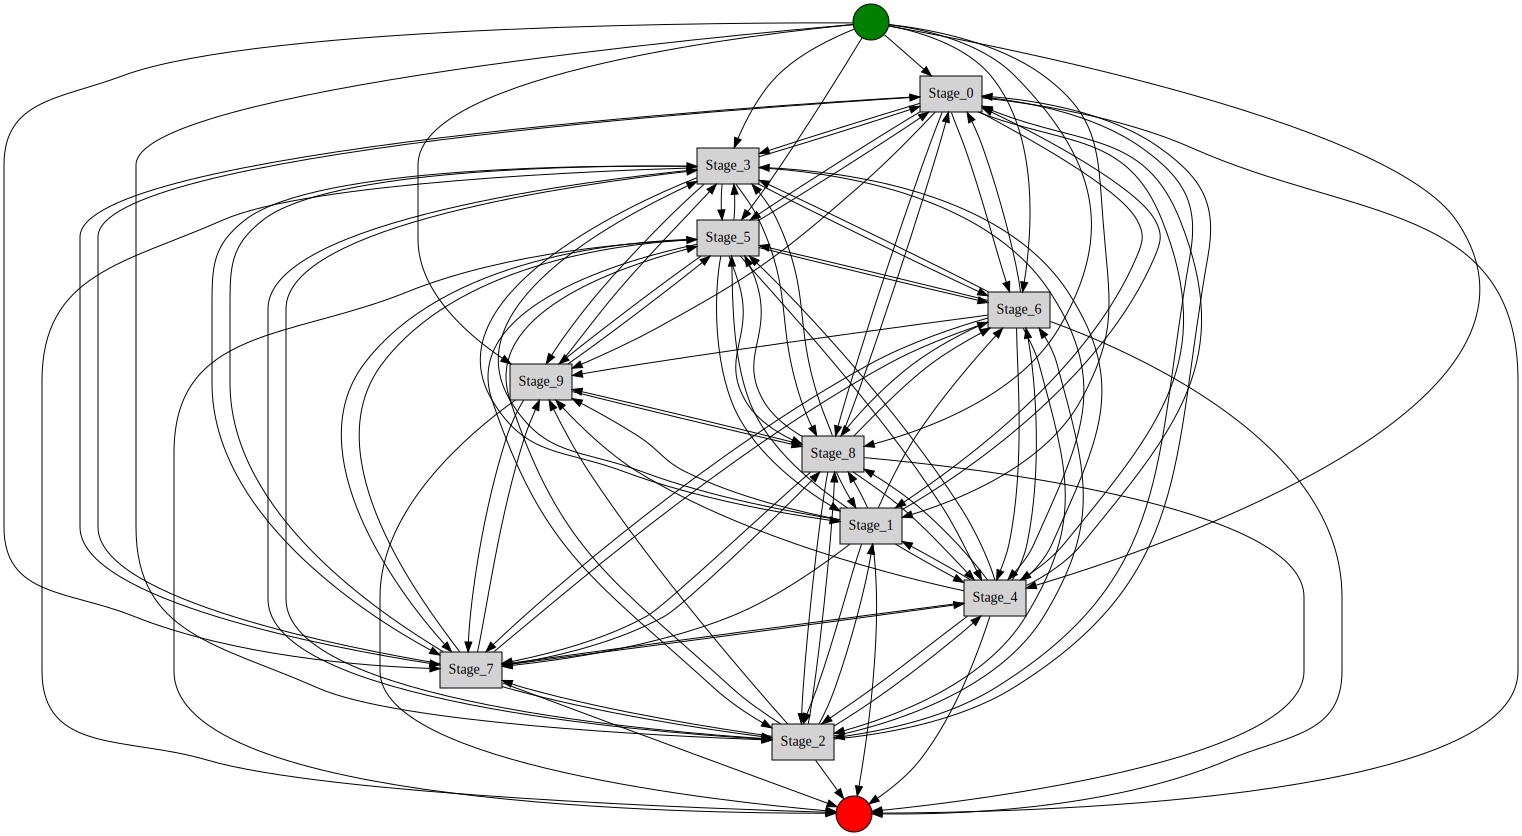

In [11]:
painter = GraphvizPainter()
painter.apply(graph)
painter.write_graph("causal_miner.png", format='png')
painter.show()

## 2. CausalMiner

`CausalMiner` filters the edges.
> Other types of relations derived from $X>Y$:
- _causal_ relation ($X \to Y$) – if $Х>Y$ and not $Y>X$
- _parallel_ relation ($X\parallel Y $) – if $Х>Y$ and $Y>X$
- _independent_ ($X\#Y$) – if not $X>Y$ and not $Y>X$

CausalMiner depicts the edge between $X$ and $Y$if $X\to Y$.

In [12]:
from sberpm.miners import CausalMiner

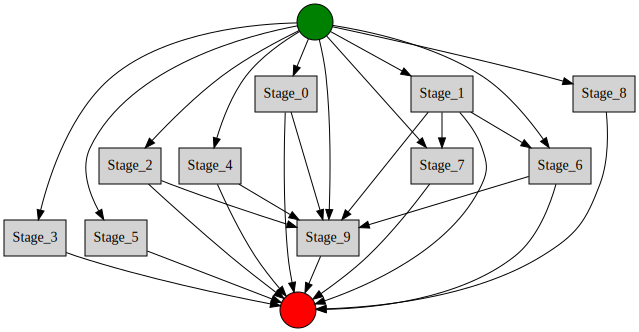

In [13]:
# Miner
causal_miner = CausalMiner(data_holder)
causal_miner.apply()
graph = causal_miner.graph

# Visualization
painter = GraphvizPainter()
painter.apply(graph)
painter.show()

## 3. HeuMiner

`HeuMiner` is a Heuristic Miner. It removes *unimportant* edges whose *unimportance* is below the given threshold. 
The **threshold** parameter must be **between 0 and 1**. The bigger it is, the less edges are depicted (the remaining ones are considered to be more important).

Source: https://www.researchgate.net/publication/229124308_Process_Mining_with_the_Heuristics_Miner-algorithm

In [14]:
from sberpm.miners import HeuMiner

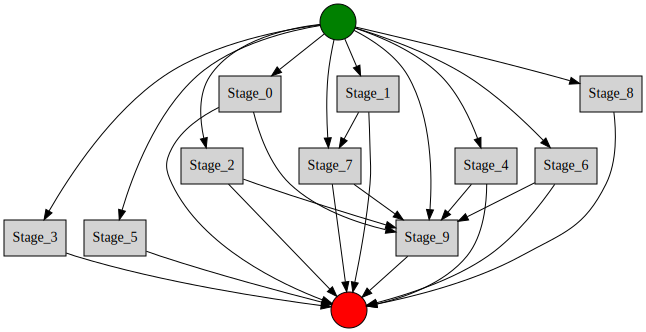

In [15]:
# Miner
heu_miner = HeuMiner(data_holder, threshold=0.8)
heu_miner.apply()
graph = heu_miner.graph

# Visualization
painter = GraphvizPainter()
painter.apply(graph)
painter.show()

## 4. AlphaMiner

`AlphaMiner` takes into consideration causal, parallel and independent relations and produces a Petri net that contains the information about parallel and XOR-like executions of the activities.

In [16]:
from sberpm.miners import AlphaMiner

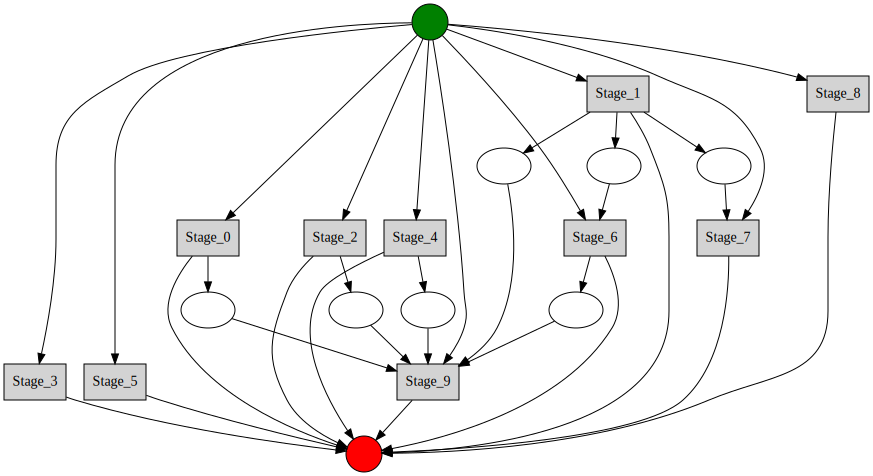

In [17]:
# Miner
alpha_miner = AlphaMiner(data_holder)
alpha_miner.apply()
graph = alpha_miner.graph

# Visualization
painter = GraphvizPainter()
painter.apply(graph)
painter.show()

## 5. AlphaPlusMiner

`AlphaPlusMiner` is an implementation of Alpha+ miner. It is a modification of Alpha Miner that can handle one-loop cases (logs where $X\to X$ relation is present).

In [18]:
from sberpm.miners import AlphaPlusMiner

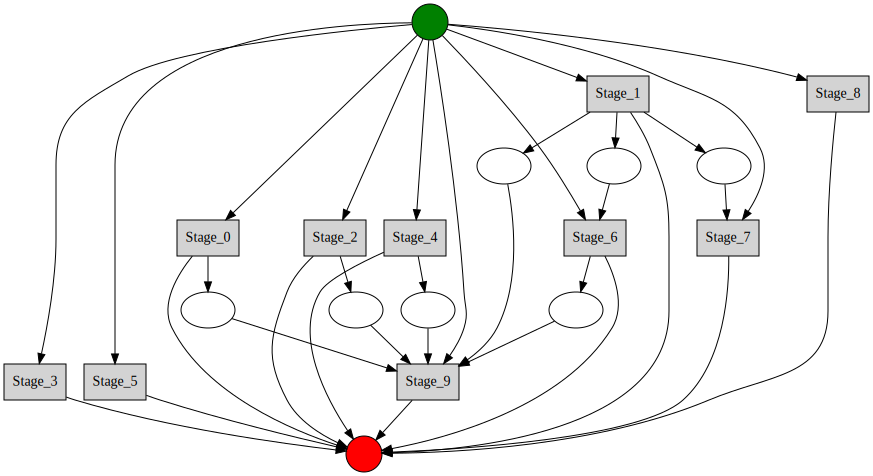

In [19]:
# Miner
alpha_miner_plus = AlphaPlusMiner(data_holder)
alpha_miner_plus.apply()
graph = alpha_miner_plus.graph

# Visualization
painter = GraphvizPainter()
painter.apply(graph)
painter.show()

### Saving and loading the Graph

In [20]:
from sberpm.visual import load_graph

In [21]:
# Saving
graph.save('graph.pkl')

In [22]:
# Loading
graph2 = load_graph('graph.pkl')

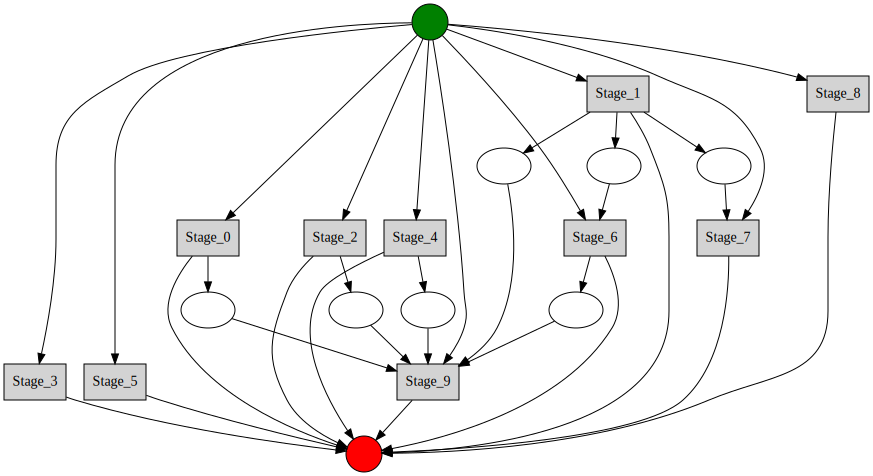

In [23]:
# Visualization
painter = GraphvizPainter()
painter.apply(graph2)
painter.show()

# Metrics

A module __`sberpm.metrics`__ offers five basic types of metrics:
1. `ActivityMetric` – metrics by activities (group by activity_column)
2. `TransitionMetric` – metrics by transitions (two consecutive activities) (group by unique transitions)
3. `IdMetric`– metrics by ids (group by id_column)
4. `TraceMetric` – metrics by event traces (group by unique traces)
5. `UserMetric` – metrics by users (group by user_column)

In [24]:
from sberpm.metrics import ActivityMetric, TransitionMetric, IdMetric, TraceMetric, UserMetric

Parameters:
- __data_holder__ – object of type DataHolder to calculate metrics for
- __time_unit__ – unit of time, by default time metrics are calculated in days
- __cycle_length__ – length of loops to detect, by default all possible loops are considered (used only in `ActivityMetric` and `TransitionMetric`)

Methods for all classes:
- __apply(...)__ – calculate all available metrics
- __calculate_time_metrics(...)__ – calculate time metrics
- __sum_time()__ – calculate the total duration
- __min_time()__ – calculate the minimum duration
- __max_time()__ – calculate the maximum duration
- __mean_time()__ – calculate the mean duration
- __median_time()__ – calculate the median duration
- __std_time()__ – calculate the standard deviation of duration
- __var_time()__ – calculate the variance of duration


Extra methods:
- for all classes except `UserMetric`:
    - __nunique_users()__ – count the number of unique users


- for `ActivityMetric` and `TransitionMetric`:
    - __count()__ – count the number of occurence
    - __cycle()__ – calculate the cycling rate


- for `IdMetric` and `TraceMetric`:
    - __len()__ – calculate the length of event traces
    - __unique_activities()__ – count the number of unique activities


- for `UserMetric`:
    - __count_activities()__ – count the number of activities per user
    - __unique_activities()__ – get unique activities per user
    - __nunique_activity()__ – count the number of unique activities per user
    - __nunique_id()__ – count the number of unique ids per user
    - __workload_in_percent()__ – calculate the workload rate per user (percent of transitions user takes part in)

### 1. ActivityMetric

In [25]:
activity_metric = ActivityMetric(data_holder, time_unit='day', cycle_length=None)
activity_metric.apply().head()

,stages,unique_ids,total_count,unique_ids_num,cycle_percent,unique_users_num,total_duration,min_duration,max_duration,mean_duration,median_duration
0,Stage_0,"{738.0, 11.0, 2.0, 234.0, 323.0, 193.0, 382.0,...",758,758,0.00,2,3789.0,1.0,9.0,5.079088,5.0
1,Stage_1,"{21.0, 444.0, 810.0, 653.0, 718.0, 456.0, 382....",213,213,0.00,3,1015.0,1.0,9.0,4.833333,5.0
2,Stage_2,"{647.0, 738.0, 2.0, 323.0, 193.0, 382.0, 657.0...",672,672,0.00,3,3301.0,1.0,9.0,5.070661,5.0
3,Stage_3,"{647.0, 738.0, 11.0, 2.0, 234.0, 323.0, 193.0,...",577,577,0.00,3,2724.0,1.0,9.0,5.082090,5.0
4,Stage_4,"{2.0, 120.0, 35.0, 140.0, 485.0, 69.0, 430.0, ...",178,178,0.00,3,836.0,1.0,9.0,5.128834,5.0


### 2. TransitionMetric

In [26]:
transition_metric = TransitionMetric(data_holder, time_unit='day', cycle_length=2)
transition_metric.apply().head()

,transition,total_count,total_duration,min_duration,max_duration,mean_duration,median_duration
0,"(Stage_3, Stage_5)",313,1620.0,1.0,9.0,5.175719,5.0
1,"(Stage_2, Stage_8)",242,1209.0,1.0,9.0,4.995868,5.0
2,"(Stage_1, Stage_7)",219,1104.0,1.0,9.0,5.041096,5.0
3,"(Stage_1, Stage_5)",184,942.0,1.0,9.0,5.119565,5.0
4,"(Stage_8, Stage_2)",178,894.0,1.0,9.0,5.022472,5.0


### 3. IdMetric

In [27]:
id_metric = IdMetric(data_holder, time_unit='day')
id_metric.apply().head()

,id,trace,trace_length,unique_activities_num,cycle_percent,unique_users_num,total_duration,min_duration,max_duration,mean_duration,median_duration
0,0.0,"(Stage_0, Stage_3, Stage_5, Stage_2, Stage_7)",5,5,0.00,5,16.0,1.0,6.0,4.000000,4.5
1,1.0,"(Stage_0, Stage_2, Stage_4, Stage_3, Stage_8)",5,5,0.00,5,15.0,2.0,5.0,3.750000,4.0
2,10.0,"(Stage_0, Stage_2, Stage_5, Stage_7)",4,4,0.00,4,16.0,3.0,8.0,5.333333,5.0
3,100.0,"(Stage_2, Stage_3, Stage_8)",3,3,0.00,3,17.0,8.0,9.0,8.500000,8.5
4,101.0,"(Stage_0, Stage_2, Stage_5, Stage_3, Stage_7, ...",7,7,0.00,7,26.0,1.0,9.0,4.333333,4.0


### 4. TraceMetric

In [28]:
trace_metric = TraceMetric(data_holder, time_unit='day')
trace_metric.apply().head()

,trace,unique_ids,total_count,trace_length,unique_activities_num,cycle_percent,unique_users,unique_users_num,total_duration,min_duration,max_duration,mean_duration,median_duration
0,"(Stage_0, Stage_2, Stage_3, Stage_5, Stage_8)","{124.0, 20.0, 158.0, 665.0, 81.0, 351.0, 936.0...",12,5,5,0.00,"{Amelia, Emma, Mary, Margaret, Oliver, Olivia,...",11,247.0,12.0,32.0,20.583333,20.5
1,"(Stage_0, Stage_2, Stage_3, Stage_8)","{320.0, 833.0, 434.0, 240.0, 832.0, 463.0, 652...",12,4,4,0.00,"{Liam, Mary, Oliver, Olivia, Isabella, Patrici...",10,196.0,8.0,25.0,16.333333,18.0
2,"(Stage_0, Stage_2, Stage_5)","{814.0, 514.0, 645.0, 565.0, 792.0, 457.0, 600...",11,3,3,0.00,"{Olivia, Oliver, Patricia, Jake, Mason, Emma, ...",7,129.0,6.0,18.0,11.727273,10.0
3,"(Stage_0, Stage_2, Stage_3, Stage_5, Stage_7, ...","{478.0, 738.0, 246.0, 227.0, 349.0, 563.0, 477...",10,6,6,0.00,"{Harry, Amelia, Emma, Mary, Margaret, Oliver, ...",14,252.0,16.0,32.0,25.200000,26.0
4,"(Stage_0, Stage_2, Stage_3, Stage_5)","{231.0, 924.0, 834.0, 981.0, 174.0, 225.0, 78....",10,4,4,0.00,"{Amelia, Emma, Margaret, Oliver, Olivia, Patri...",9,161.0,11.0,25.0,16.100000,14.5


### 5. UserMetric

In [29]:
user_metric = UserMetric(data_holder, time_unit='day')
user_metric.apply().head()

,users,unique_activities,unique_activities_num,activities_count,unique_ids_num,workload_in_percent,total_duration,min_duration,max_duration,mean_duration,median_duration
0,Amelia,{Stage_3},1,184,184,4.12,872.0,1.0,9.0,5.011494,5.0
1,Barbara,{Stage_9},1,136,136,3.05,96.0,1.0,9.0,5.333333,6.0
2,Bethany,{Stage_4},1,56,56,1.26,245.0,1.0,9.0,4.900000,5.0
3,Callum,{Stage_7},1,167,167,3.74,593.0,1.0,9.0,5.201754,5.0
4,Charlie,{Stage_1},1,67,67,1.50,299.0,1.0,9.0,4.530303,4.0


### TokenReplay

`TokenReplay` allows to compute *fitness* that indicates to what extent a Petri net captures a business process (1 for good, 0 for bad). Fitness is calculated for each event trace (id) by replaying it in the given Petri net as follows: 
$$ Fitness = \frac{1}{2}\big(1-\frac{missed}{consumed}\big) + \frac{1}{2}\big(1-\frac{remaining}{produced}\big) $$
- $produced$ – the number of produced tokens
- $consumed$ – the number of consumed tokens
- $remaining$ – the number of remaining tokens
- $missing$ – the number of missing tokens

The following metrics can be obtained:
- values of the four components and fitness for each event traces
- mean fitness of all traces (__mean_fitness__)
- fitness of the log by substituting the values in the formula by sum of the corresponding values of each event trace  (__average_fitness__)

In [30]:
from sberpm.metrics import TokenReplay

In [31]:
token_replay = TokenReplay(data_holder, alpha_miner.graph)
token_replay.apply()
token_replay.result

,id,stages,c,p,m,r,fitness
0,0.0,"(Stage_0, Stage_3, Stage_5, Stage_2, Stage_7)",7,8,5,6,0.267857
1,1.0,"(Stage_0, Stage_2, Stage_4, Stage_3, Stage_8)",6,9,4,7,0.277778
2,10.0,"(Stage_0, Stage_2, Stage_5, Stage_7)",6,7,4,5,0.309524
3,100.0,"(Stage_2, Stage_3, Stage_8)",4,5,2,3,0.450000
4,101.0,"(Stage_0, Stage_2, Stage_5, Stage_3, Stage_7, ...",14,10,10,6,0.342857
...,...,...,...,...,...,...,...
994,995.0,"(Stage_0, Stage_2, Stage_5)",4,6,2,4,0.416667
995,996.0,"(Stage_3, Stage_2, Stage_5, Stage_7, Stage_8)",7,7,5,5,0.285714
996,997.0,"(Stage_0, Stage_2, Stage_3, Stage_5, Stage_6, ...",10,11,8,9,0.190909
997,998.0,"(Stage_0, Stage_1, Stage_2, Stage_3, Stage_9)",11,11,6,6,0.454545


In [32]:
print('mean:', token_replay.mean_fitness)
print('average:', token_replay.average_fitness)

mean: 0.36138350149788057
average: 0.3365537369071906


# Metrics + Graphs

In _sberpm_ there is an opportunity to visualize metrics on the graph. In order to do it, one can use `Graph` class that has the following methods:
- __add_node_metric(...)__ – add metric to the graph node
- __add_edge_metric(...)__ – add metric to the graph edge

In [33]:
# Calculation of the metrics
nodes_count_metric = activity_metric.count().to_dict()
edges_count_metric = transition_metric.count().to_dict()
mean_time_node_metric = activity_metric.mean_time().fillna(0).to_dict()

# Getting the graph
graph = causal_miner.graph

# Adding the metrics to the graph
graph.add_node_metric('count', nodes_count_metric)
graph.add_edge_metric('count', edges_count_metric)
graph.add_node_metric('mean_time', mean_time_node_metric)

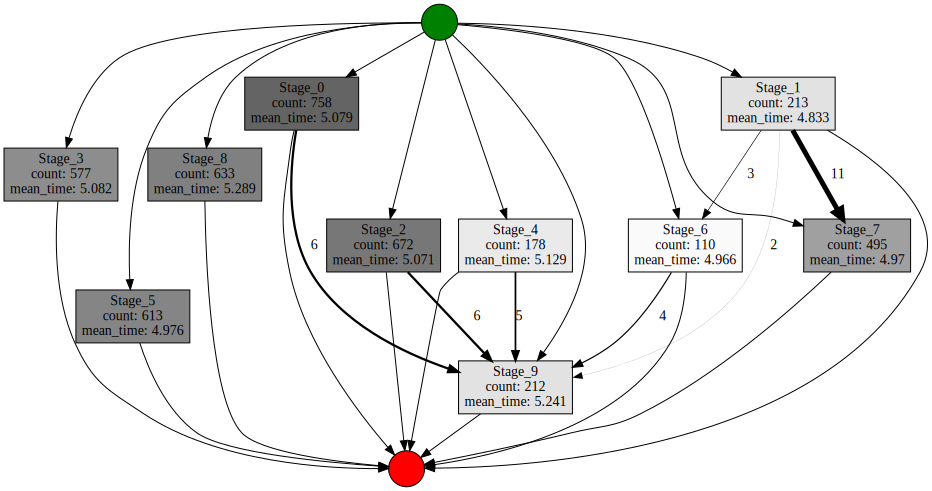

In [34]:
painter = GraphvizPainter()

# Specify which metrics influence the nodes' colors and the edges' widths
painter.apply(graph, node_style_metric='count', edge_style_metric='count')
# or 
# painter.apply(graph, node_style_metric='mean_time', edge_style_metric='count')

painter.write_graph("metric_graph.png", format = 'png')
painter.show()

To delete metrics from the graph, the following methods should be used:
- __clear_node_metrics(...)__ – delete all metrics from nodes
- __clear_edge_metrics__ – delete all metrics from edges

In [35]:
graph.clear_node_metrics()
graph.clear_edge_metrics()

# BPMN

In order to save process graph in a BPMN (Business Process Model and Notation) format, one can use `BpmnExporter` from __`sberpm.bpmn`__ module. It has the following methods:
- __apply_petri(...)__ – construct BPMN for a Petri net 
- __get_string_representation()__ – get BPMN notation of the graph
- __write(...)__ – write graph in a BPMN format to file

At this moment, only Petri nets can be converted to BPMN.

In [36]:
from sberpm.bpmn import BpmnExporter

In [37]:
bpmn_exporter = BpmnExporter()
bpmn_exporter.apply_petri(alpha_miner.graph)
bpmn_exporter.get_string_representation()[:1000]

C:\Users\Sergey\Anaconda3\lib\site-packages\sberpm\bpmn\_bpmn_graph_to_file\_bpmn_exporter.py:63: RuntimeWarning: Impossible to create orthogonal edges, splines will be created instead.
  warnings.warn("Impossible to create orthogonal edges, splines will be created instead.", RuntimeWarning)


'<bpmn:definitions id="Definitions_123" targetNamespace="http://bpmn.io/schema/bpmn" xmlns:bpmn="http://www.omg.org/spec/BPMN/20100524/MODEL" xmlns:bpmndi="http://www.omg.org/spec/BPMN/20100524/DI" xmlns:dc="http://www.omg.org/spec/DD/20100524/DC" xmlns:di="http://www.omg.org/spec/DD/20100524/DI">\n\t<bpmn:process id="Process_123">\n\t\t<bpmn:task bpmn:incoming="sequenceFlow_15" bpmn:outgoing="sequenceFlow_0" id="task_0" name="Stage_0" />\n\t<bpmn:parallelGateway bpmn:incoming="sequenceFlow_0" bpmn:outgoing="sequenceFlow_11" id="parallelGateway_0" />\n\t<bpmn:task bpmn:incoming="sequenceFlow_16" bpmn:outgoing="sequenceFlow_1" id="task_1" name="Stage_3" />\n\t<bpmn:exclusiveGateway bpmn:incoming="sequenceFlow_1" bpmn:outgoing="sequenceFlow_22" id="exclusiveGateway_0" />\n\t<bpmn:task bpmn:incoming="sequenceFlow_17" bpmn:outgoing="sequenceFlow_2" id="task_2" name="Stage_5" />\n\t<bpmn:task bpmn:incoming="sequenceFlow_18" bpmn:outgoing="sequenceFlow_3" id="task_3" name="Stage_2" />\n\t<bp

In [38]:
bpmn_exporter.write('exported.bpmn')

To load BPMN file, class `BpmnImporter` with the following methods can be used:
- __load_bpmn_from_xml__ – load BPMN graph
- __get_pydotplus_graph__ – get graph in a pydotplus format

In [39]:
from sberpm.bpmn import BpmnImporter

In [40]:
bpmn_importer = BpmnImporter()
bpmn_importer.load_bpmn_from_xml('exported.bpmn')
pydot_graph = bpmn_importer.get_pydotplus_graph()
pydot_graph.write('imported_bpmn.svg', prog='dot', format='svg')

True

# Machine learning

A module for machine learning __`sberpm.ml`__ allows for process vectorization and clustering. New analytical instruments will be available later.

### Process Vectorization

For process vectorization the class `ProcessCountVectorizer` from module __`sberpm.ml.vectorizer`__ can be used. It transforms  each event trace to a corresponding vector.

In [41]:
from sberpm.ml.vectorizer import ProcessCountVectorizer

In [42]:
vectorizer = ProcessCountVectorizer()
embeddings = vectorizer.transform(data_holder)

Methods of `ProcessCountVectorizer`:
- __transform(...)__ – return vectors for each event trace in the given DataHolder

### Clustering

After the process is vectorized, the obtained vectors can be clustered with `GraphClustering` from __`sberpm.ml.processes`__.

Для кластеризации векторов в библиотеке есть класс `GraphClustering` в модулях __`sberpm.ml.processes`__

In [43]:
from sberpm.ml.processes import GraphClustering

Methods of `GraphClustering`:
- __fit(...)__ – compute clustering
- __predict(...)__ – predict cluster index for each event trace
- __add_cluster_column(...)__ – add column with cluster index to the grouped data
- __predict_add(...)__ – compute clustering and add predicted cluster index to the grouped data

In [44]:
estimator = GraphClustering()
estimator.fit(embeddings)
clusters = estimator.predict(embeddings)

# Autoinsights

An autoinsight module __`sberpm.autoinsights`__ provides means to automatically detect process problems such as bottlenecks and deviations and map them on the process graph. By using the class `AutoInsights`, the following factors are taken into account:
1. Transition duration and workload
2. Utilization rate of transition
3. Process loops and repetitions

`AutoInsights` contains the following parameters:
- __data_holder__ – pandas.DataFrame or sberpm.DataHolder
- __time_unit__ – unit of time duration values, by default time metrics are calculated in _days_
- __cycle_length__ – length of loops detected by the algorithm, by default it looks for all possible loops

In [45]:
from sberpm.autoinsights import AutoInsights

In [46]:
# Initialization
auto_i = AutoInsights(data_holder, time_unit='day', cycle_length=None)

`AutoInsights` has the following methods:
- __apply(...)__ – find inefficiencies in the input log
- __get_graph()__ – return process graph with discovered autoinsights, the type depends on the __mode__ parameter in the __apply(...)__ method
- __describe_nodes()__ – return the table of activities with the autoinsight metric indicator
- __describe_edges()__ – return the table of transitions with the autoinsight metric indicator

Parameters of the __apply(...)__ method:
- __miner__ – miner to use to search for inefficiencies
- __mode__ – autoinsight search mode, can be either *time*, *cycles* or *overall*, by default *overall*
- __width_by_insight__ – if True, the edges' width on the graph will correspond to the "insight" status
- __q_min__ – the lower quantile for the algorithm, by default 0.1
- __q_max__ – the upper quantile for the algorithm, by default 0.85

Other methods do not require any parameters.

### Autoinsight Visualization

Three ways of visualizations are supported at the moment:
- By transition duration __(mode='time')__ – the longest-lasting transitions are colored red
- By cycling __(mode='cycles')__ – transitions with returns are colored blue, the loops themselves are not reflected
- Hybrid method __(mode='overall')__ – all transitions are given a status (one of three):
    -  __Optimal__ (positive insights)
    - __<font color='grey'>No insight</font>__
    - __<font color='red'>Need for optimization</font>__ (negative insights)
    
The mean duration and the return rate for both optimal insights and the ones demanding optimization are displayed in the corner of the image. 


In [47]:
# Transition duration
auto_i.apply(miner=simple_miner, mode='time')
graph = auto_i.get_graph()

painter = GraphvizPainter()
painter.apply_insights(graph)
g = painter.show()
g.view()

'Digraph.gv.pdf'

In [48]:
# Loops
auto_i.apply(miner=simple_miner, mode='cycles')
graph = auto_i.get_graph()

painter = GraphvizPainter()
painter.apply_insights(graph)
g = painter.show()
g.view()

'Digraph.gv.pdf'

In [49]:
# Hybrid mode
auto_i.apply(miner=simple_miner, mode='overall')
graph = auto_i.get_graph()

painter = GraphvizPainter()
painter.apply_insights(graph)
g = painter.show()
g.view()

'Digraph.gv.pdf'

### Description of the Results

The results are set out in a table format. For each element insight and metric indicators are given: 
- __1__ – negative insight
- __0__ – not insight
- __-1__ – positive insight

In [50]:
auto_i.describe_nodes().head()

,activities,count,mean_time,cycle,nunique_users,insights
0,Stage_0,1,0,0,0,1
1,Stage_1,0,-1,0,0,-1
2,Stage_2,1,0,0,0,1
3,Stage_3,0,0,0,0,0
4,Stage_4,0,0,0,0,0


In [51]:
auto_i.describe_edges().head()

,edges,count,mean_time,cycle,nunique_users,insights
0,"(Stage_0, Stage_1)",1,0,0,0,1
1,"(Stage_0, Stage_2)",1,0,0,0,1
2,"(Stage_0, Stage_3)",1,0,0,0,1
3,"(Stage_0, Stage_4)",0,0,0,0,0
4,"(Stage_0, Stage_5)",0,0,0,0,0
